# **Đồ án nhỏ 1: Phân loại Chất lượng Rượu vang 🍷**

**Yêu cầu:** Sử dụng bộ dữ liệu winequality-red.csv được đề cập trong báo cáo[cite: 7299]. Xây dựng một pipeline hoàn chỉnh để dự đoán chất lượng rượu vang (bài toán phân loại, có thể phân loại chất lượng thành 'tốt'/'xấu'). 

Bao gồm: 

1. EDA (Phân tích dữ liệu khám phá) với các trực quan hóa. 
2. Tiền xử lý (StandardScaler). 
3. Huấn luyện nhiều mô hình (ví dụ: LogisticRegression, RandomForestClassifier). 
4. Đánh giá bằng các chỉ số phân loại phù hợp và cross-validation. 
5. (Tùy chọn) Tinh chỉnh siêu tham số cho mô hình tốt nhất. 

**Mục tiêu:** Áp dụng quy trình ML từ đầu đến cuối bằng Scikit-learn cho bài toán phân loại.


## 1. Định nghĩa vấn đề (Define Problem)
- **Mô tả**:
    - Tập “Red Vinho Verde” (Bồ Đào Nha) thuộc bộ Wine Quality gốc UCI, được mirror trên Kaggle. Dữ liệu chỉ gồm thử nghiệm hoá lý và điểm cảm quan “quality”.
+ **Dữ liệu vào**:
    - fixed acidity - axit cố định 
    - volatile acidity - axit bay hơi
    - citric acid - axit citric
    - residual sugar - đường dư 
    - chlorides - Ion Clorua
    - free sulfur dioxide - SO2 chưa liên kết 
    - total sulfur dioxide - Tổng SO2 
    - density - khối lượng riêng của rượu
    - pH - mức đô axit/bazo của rượu
    - sulphates - hàm lượng ion sunfat trong rượu
    - alcohol - lượng ethanol theo thể tích trong rượu
+ **Kết quả**: quality (3-8)

## 2. Chuẩn bị vấn đề (Prepare Problem)

### 2.1. Khai báo thư viện (Load Libraries)

In [3]:
import pandas as pd # Xử lý dữ liệu bảng (lọc nhóm, gộp, missing vaules)
import numpy as np # Tính toán với mảng, thống kê...
import matplotlib.pyplot as plt # Vẽ biểu đồ linh hoạt tùy biến
import seaborn as sns # Vẽ biểu đồ thống kê dựa vào matplotlib
from IPython.display import display
# tách và CV
from sklearn.model_selection import (
    train_test_split,      # tách train/test có stratify để giữ tỉ lệ lớp
    StratifiedKFold,       # k-fold giữ phân bố lớp ổn định cho phân loại
    cross_validate,        # chạy cross-validation nhiều metric cùng lúc
    GridSearchCV           # (tùy chọn) tinh chỉnh siêu tham số mô hình
)
# tiền xử lý và pipeline
from sklearn.preprocessing import StandardScaler   # chuẩn hóa đặc trưng số (z-score)
from sklearn.compose import ColumnTransformer      # áp dụng scaler theo cột
from sklearn.pipeline import Pipeline              # xâu chuỗi preprocess + model, tránh rò rỉ
# --- Models ---
from sklearn.tree import DecisionTreeClassifier    # baseline dễ diễn giải
from sklearn.ensemble import RandomForestClassifier# mô hình mạnh, giảm phương sai, có feature_importances_
# Evaluation S
from sklearn.metrics import (
    accuracy_score,           # độ chính xác tổng thể
    precision_score,          # % dự đoán good đúng trên toàn bộ dự đoán good
    recall_score,             # % bắt được good trong tất cả mẫu good
    f1_score,                 # trung hòa precision/recall (quan trọng khi lệch lớp)
    roc_auc_score,            # chất lượng xếp hạng xác suất (AUC)
    confusion_matrix,         # ma trận nhầm lẫn để xem TP/FP/TN/FN
    classification_report     # bảng tổng hợp precision/recall/F1 theo lớp
)
# --- Persistence ---
import joblib   # lưu/đọc pipeline đã huấn luyện: joblib.dump(...), joblib.load(...)


### 2.2. Nạp dữ liệu (Load Dataset)

In [4]:
winequality_df = pd.read_csv("winequality-red.csv")
winequality_df.head() # hiển thị 5 rows đầu tiên của dataset, head(default = 5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


- Edit those columns (ex: fixed acidity -> fixed_acidity )

### 2.3. Thay đổi tên cột (Columns name change)

In [5]:
# winequality_df = winequality_df.rename(columns={"fixed acidity": "fixed_acidity"}) #single
cols_to_fix = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "free sulfur dioxide", "total sulfur dioxide"]
def normalize_selected_cols(df, cols):
    mapping = {c:c.strip().lower().replace(" ", "_") for c in cols}
    return df.rename(columns = mapping)

winequality_df = normalize_selected_cols(winequality_df, cols_to_fix) # col_to_fix:liệt kê đúng các cột cần sửa.
winequality_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 4. EDA

### 4.1. Thống kê cơ bản

In [6]:
# Thống kê cơ bản
display(winequality_df.describe().T)
print(winequality_df.isna().sum())

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile_acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric_acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual_sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free_sulfur_dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total_sulfur_dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


### 4.2. Tương quan

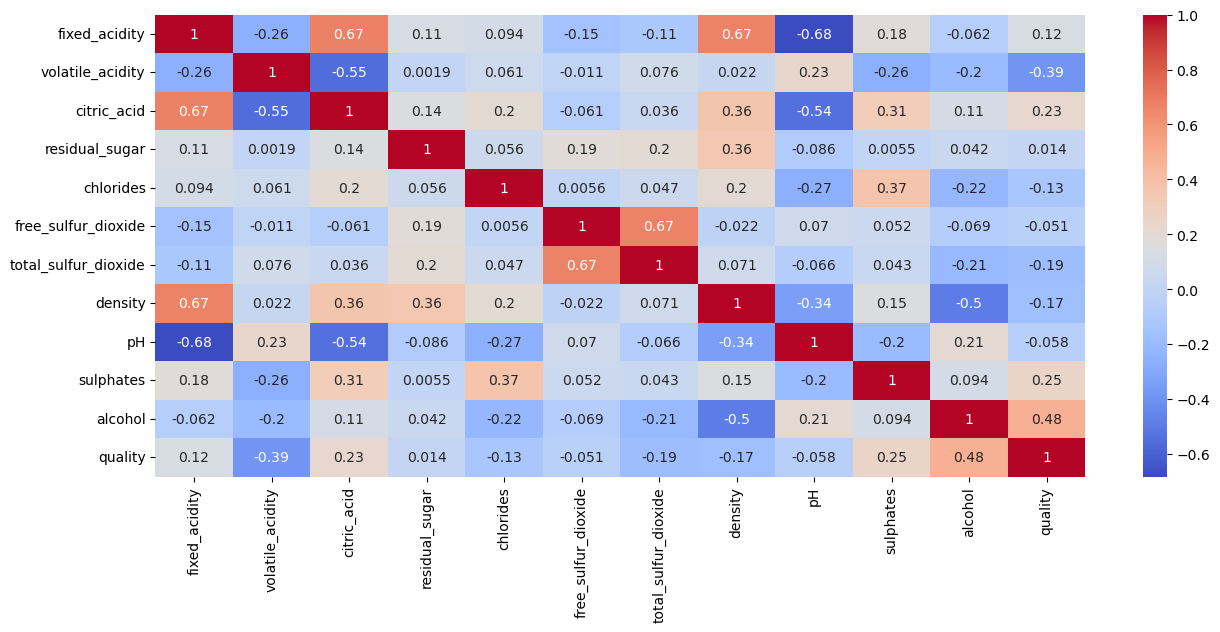

In [7]:
plt.figure(figsize=(15, 6)) #Create canvas
sns.heatmap(winequality_df.corr(), annot= True, cmap="coolwarm") # annot để hiển thị số và cmap để hiển thị màu
plt.show() 

## 5. Tiền xử lý

In [8]:
# num_features: các cột ảnh hưởng đến chất lượng rượu
num_features = [
    "fixed_acidity",           # axit cố định
    "volatile_acidity",        # axit bay hơi
    "citric_acid",             # axit citric
    "chlorides",               # ion clorua
    "total_sulfur_dioxide",    # tổng SO2
    "density",                 # khối lượng riêng
    "sulphates",               # ion sunfat
    "alcohol"                  # nồng độ ethanol
]
# target: cột nhãn (biến phụ thuộc) cần dự đoán
target = "quality"

In [9]:
# Tách X (features) và y (target)
X = winequality_df[num_features]
y = winequality_df[target]

# --- Tách dữ liệu train/test ---
# 20% train, stratify (phân bố các nhãn trong y được giữ nguyên ở cả hai tập.)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42 
)
# tiền xử lý cho các cột số
# StandardScaler sẽ chuẩn hóa mỗi cột về mean=0 và std=1 (z-score normalization)
#remainder="drop" (loại bỏ cột không có trong num_features) 
preprocess = ColumnTransformer( # sử dụng trên cột số
    transformers=[("num", StandardScaler(), num_features)], remainder="drop", 
)

# Xây dựng model

In [10]:
# --- Xây dựng Pipeline cho 2 mô hình phân loại ---
# Pipeline 1: Decision Tree Classifier
# Pipeline kết hợp preprocess (chuẩn hóa) + classifier (cây quyết định)
# class_weight="balanced" tự động cân bằng trọng số các lớp (giúp mô hình chú ý nhiều hơn vào lớp thiểu số)
dt_clf = Pipeline(steps=[
    ("prep", preprocess),  
    ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced")),
])

# Pipeline 2: Random Forest Classifier
rf_clf = Pipeline(steps=[
    ("prep", preprocess),  # Bước 1: chuẩn hóa
    ("clf", RandomForestClassifier(
        n_estimators=300,              # số cây trong rừng 
        random_state=42,     # seed để tái lập kết quả
        class_weight="balanced"        # cân bằng lớp tự động
    )),
])

# Đánh giá model

In [11]:
# Thiết lập StratifiedKFold để cross-validation giữ tỷ lệ lớp đồng đều (chia k fold)
# n_splits=5 chia dữ liệu thành 5 folds, mỗi lần test trên 1 fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # shuffle xáo dữ liệu trước khi chia các fold

# Nhị phân hoá quality: ≥6 → 1 (good), <6 → 0 (bad) để tiện dùng/diễn giải precision/recall/F1/ROC-AUC
y_binary = (y >= 6).astype(int)
y_train_binary = (y_train >= 6).astype(int)
y_test_binary = (y_test >= 6).astype(int)

# các metric để đánh giá trong cross-validation
scoring = {"accuracy":"accuracy","precision":"precision","recall":"recall","f1":"f1","roc_auc":"roc_auc"}

In [12]:
def evaluate(name, pipe):
    #  Cross-Validation trên toàn bộ dữ liệu (dùng y_binary) 
    cv_res = cross_validate(pipe, X, y_binary, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"\n===== {name}: 5-fold CV =====")
    for k, v in cv_res.items():
        if k.startswith("test_"):
            print(f"{k[5:]:>9}: {np.mean(v):.3f} ± {np.std(v):.3f}")
    # Huấn luyện
    pipe.fit(X_train, y_train_binary) 
    y_pred  = pipe.predict(X_test)  
    # Lấy xác suất cho lớp dương (cột 1) nếu model hỗ trợ predict_proba
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe[-1], "predict_proba") else None

    print("\n-- Holdout (20%) --")
    print("Accuracy :", accuracy_score(y_test_binary, y_pred))    # % dự đoán đúng tổng thể
    print("Precision:", precision_score(y_test_binary, y_pred))   # % dự đoán good đúng
    print("Recall   :", recall_score(y_test_binary, y_pred))      # % bắt được good
    print("F1       :", f1_score(y_test_binary, y_pred))          # trung bình điều hòa precision/recall
    if y_proba is not None:
        print("ROC-AUC  :", roc_auc_score(y_test_binary, y_proba))  # diện tích dưới đường cong ROC
    
    # Ma trận nhầm lẫn: [[TN, FP], [FN, TP]]
    print("\nConfusion matrix:\n", confusion_matrix(y_test_binary, y_pred))
    # Báo cáo chi tiết theo từng lớp
    print("\nClassification report:")
    print(classification_report(y_test_binary, y_pred, target_names=["Bad (<6)", "Good (>=6)"], digits=3)) # số chữ số thập phân hiển thị

# Đánh giá DecisionTree pipeline
evaluate("DecisionTree", dt_clf)
# Đánh giá RandomForest pipeline
evaluate("RandomForest", rf_clf)



===== DecisionTree: 5-fold CV =====
 accuracy: 0.742 ± 0.029
precision: 0.753 ± 0.028
   recall: 0.770 ± 0.033
       f1: 0.761 ± 0.028
  roc_auc: 0.740 ± 0.029

-- Holdout (20%) --
Accuracy : 0.7125
Precision: 0.7231638418079096
Recall   : 0.7485380116959064
F1       : 0.735632183908046
ROC-AUC  : 0.7098394756466108

Confusion matrix:
 [[100  49]
 [ 43 128]]

Classification report:
              precision    recall  f1-score   support

    Bad (<6)      0.699     0.671     0.685       149
  Good (>=6)      0.723     0.749     0.736       171

    accuracy                          0.713       320
   macro avg      0.711     0.710     0.710       320
weighted avg      0.712     0.713     0.712       320


===== RandomForest: 5-fold CV =====
 accuracy: 0.805 ± 0.029
precision: 0.818 ± 0.018
   recall: 0.819 ± 0.052
       f1: 0.818 ± 0.031
  roc_auc: 0.891 ± 0.031

===== RandomForest: 5-fold CV =====
 accuracy: 0.805 ± 0.029
precision: 0.818 ± 0.018
   recall: 0.819 ± 0.052
       f1: 0

# Siêu tham số

In [16]:
# Tạo lại pipeline RandomForest để tuning
rf_base = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(random_state=42, class_weight="balanced")),
])

# "clf__<tên_tham_số>" để truy cập tham số của RandomForestClassifier trong pipeline
param_grid = {
    "clf__n_estimators": [200, 400, 600],           # số cây trong rừng
    "clf__max_depth": [None, 8, 12, 16],            # độ sâu tối đa của mỗi cây (None = không giới hạn)
    "clf__min_samples_split": [2, 5, 10],           # số mẫu tối thiểu để tách node
    "clf__min_samples_leaf": [1, 2, 4],             # số mẫu tối thiểu ở mỗi lá
    "clf__max_features": ["sqrt", "log2", 0.5],     # số feature xem xét khi tách (sqrt/log2/50%)
}

In [17]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    rf_base,
    param_grid=param_grid,
    cv=cv,                # StratifiedKFold(5) đã định nghĩa
    scoring="f1",         # tối ưu F1 cho dữ liệu lệch lớp
    n_jobs=-1,            # dùng hết CPU
    verbose=1             # in tiến trình
)
grid.fit(X_train, y_train_binary)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['fixed_acidity',
                                                                          'volatile_acidity',
                                                                          'citric_acid',
                                                                          'chlorides',
                                                                          'total_sulfur_dioxide',
                                                                          'density',
                                                                          'sulphates',
                                                                          'alcohol'])])),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 8, 12, 16],
                         'clf__max_features': ['sqrt', 'log2', 0.5],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [200, 400, 600]},
             scoring='f1', verbose=1)

In [18]:
print("\n[Best params]", grid.best_params_)
print("[Best CV F1 ]", grid.best_score_)
best_model = grid.best_estimator_



[Best params] {'clf__max_depth': 16, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
[Best CV F1 ] 0.821550946087412


In [19]:
y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n== RF (best) | Holdout ==")
print("F1      :", f1_score(y_test_binary, y_pred))
print("ROC-AUC :", roc_auc_score(y_test_binary, y_proba))



== RF (best) | Holdout ==
F1      : 0.8242074927953891
ROC-AUC : 0.8787236547745202


# Lưu mô hình 

In [ ]:
# Lưu pipeline đã huấn luyện vào file .joblib
# Ưu tiên lưu best_model (sau GridSearchCV) nếu đã tồn tại
# Nếu không có best_model, fit và lưu rf_clf thông thường
# joblib hiệu quả hơn pickle cho các mô hình scikit-learn có numpy arrays lớn
# File .joblib có thể load lại sau này bằng: model = joblib.load("rf_winequality_best.joblib")
joblib.dump(best_model if 'best_model' in globals() else rf_clf.fit(X_train, y_train),
            "../models/rf_winequality_best.joblib")
print("Đã lưu: rf_winequality_best.joblib")

#TEST
# Lưu ý: Để dự đoán sau này, chỉ cần:
# loaded_model = joblib.load("rf_winequality_best.joblib")
# predictions = loaded_model.predict(new_data)

Đã lưu: rf_winequality_best.joblib
